## Analysis of the Influence of Campaign Contributions and Incumbency on the Outcome of the 2016 House of Representatives Election Cycle

In [1]:
from warnings import simplefilter
simplefilter(action='ignore', category=Warning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import scipy.stats as stats
import statsmodels.api as sm
import seaborn as sns 
plt.style.use('seaborn-v0_8')
import pingouin as pg
from sklearn.metrics import *

### Data Inspection and Preparation

In [2]:
df = pd.read_csv('campaign_finance_data_2016.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1814 entries, 0 to 1813
Data columns (total 51 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   can_id                 1814 non-null   object 
 1   can_nam                1814 non-null   object 
 2   can_off                1814 non-null   object 
 3   can_off_sta            1814 non-null   object 
 4   can_off_dis            1812 non-null   float64
 5   can_par_aff            1813 non-null   object 
 6   can_inc_cha_ope_sea    1812 non-null   object 
 7   can_str1               1789 non-null   object 
 8   can_str2               122 non-null    object 
 9   can_cit                1813 non-null   object 
 10  can_sta                1806 non-null   object 
 11  can_zip                1789 non-null   float64
 12  ind_ite_con            1570 non-null   object 
 13  ind_uni_con            1538 non-null   object 
 14  ind_con                1616 non-null   object 
 15  par_

Text(0.5, 1.0, 'Missing Values Bar Chart')

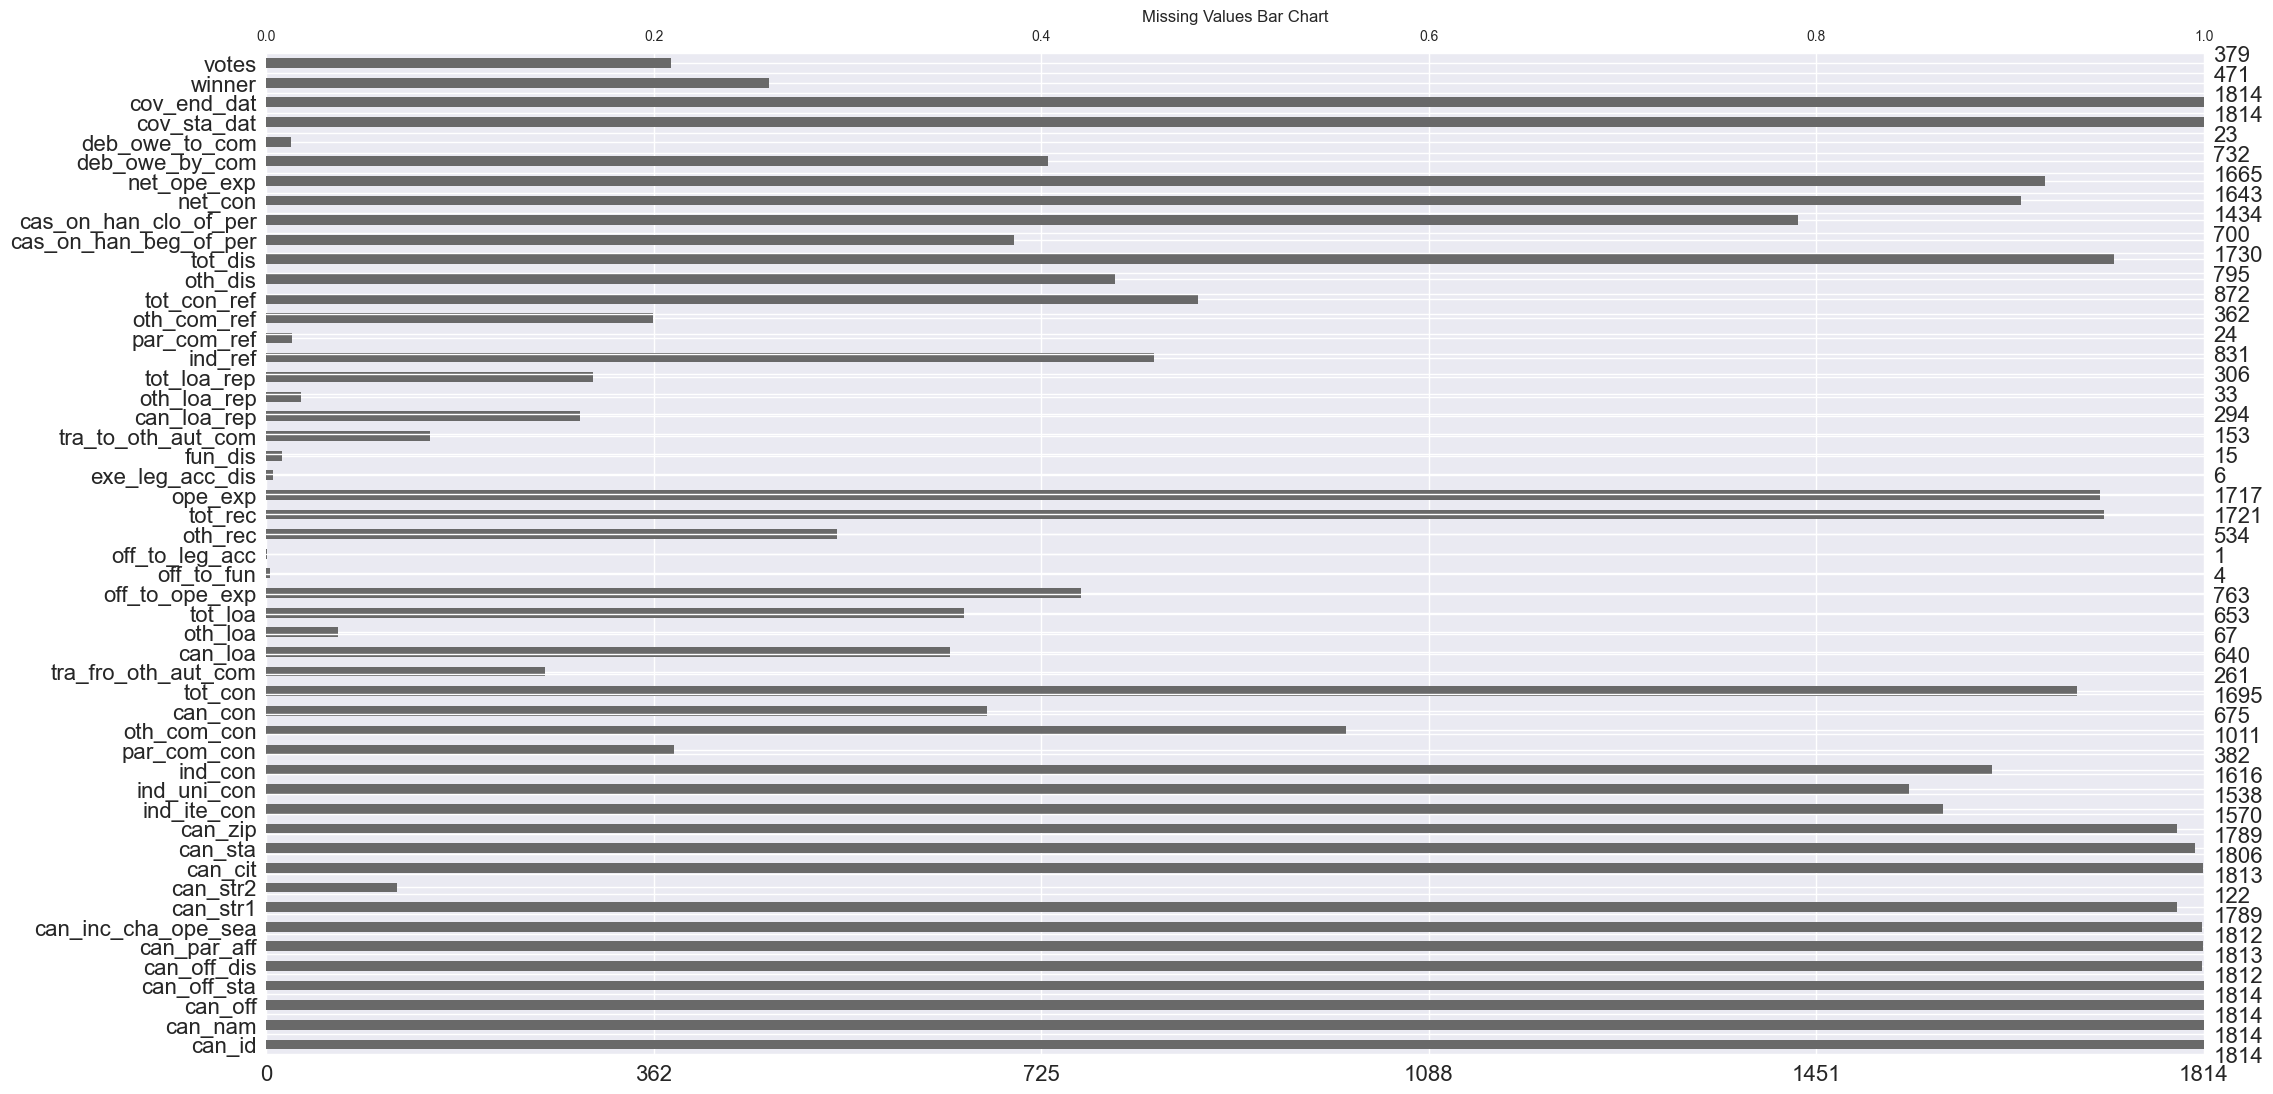

In [3]:
msno.bar(df)
plt.title('Missing Values Bar Chart')

Text(0.5, 1.0, 'Missing Values Heat Map')

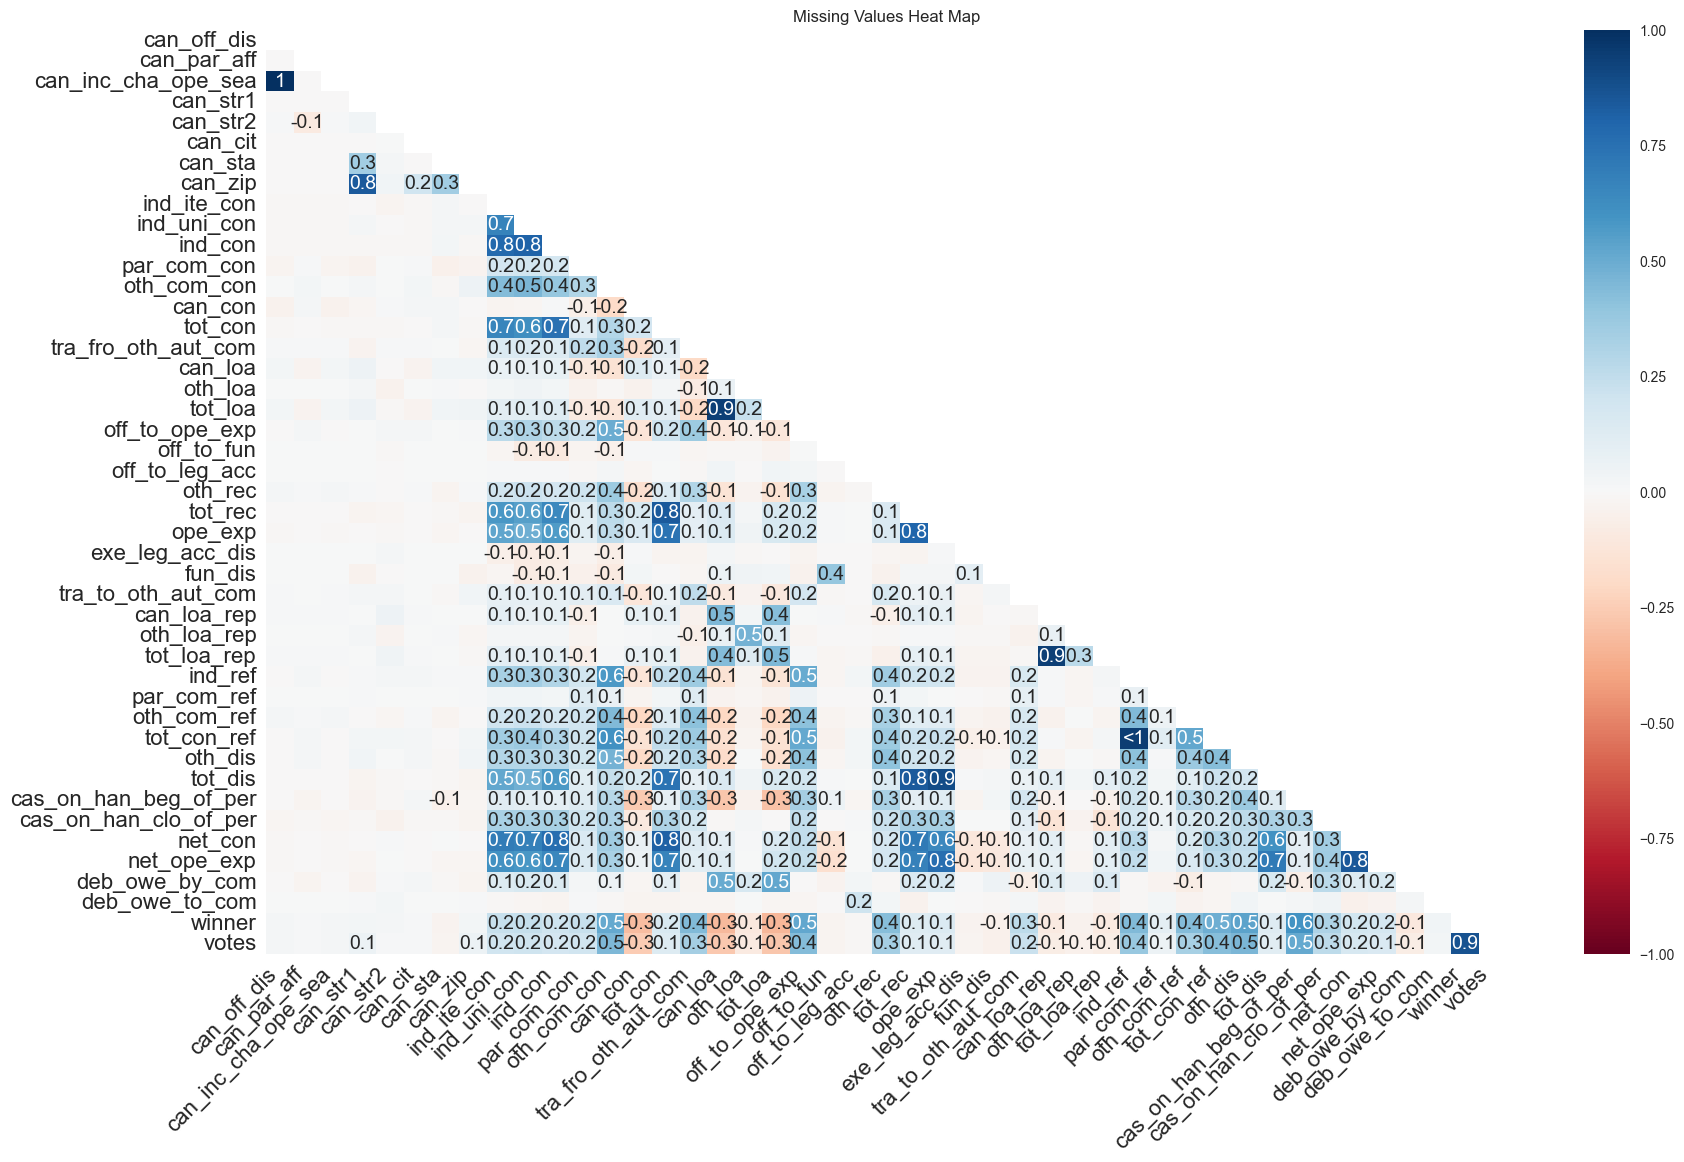

In [4]:
msno.heatmap(df)
plt.title('Missing Values Heat Map')

In [5]:
# The foregoing check revealed a large amount of missing and extraneous data to be dropped below, leaving only total 
# received campaign contributions (converted from string to float), party affiliation (converted from string to int), 
# total votes received, and election outcome (converted from string to int).

cols = ['name', 'party', 'inc', 'tot_rec', 'votes', 'winner']

df.rename(columns={'can_nam':'name', 'can_par_aff':'party','can_inc_cha_ope_sea':'inc'}, inplace=True)
        
house = df[df['can_off']=='H'][cols]

print('Shape:', np.shape(house))
print()
print(house.isna().sum())
print('\nProportion of candidates with missing vote data:', round(house.isna().sum()['votes']/np.shape(house)[0], 2))
print('Proportion of candidates who received no public campaign contributions:', round(house.isna().sum()['tot_rec']/np.shape(house)[0], 2))
print('Number of winners:', np.shape(house[house['winner']=='Y']))


Shape: (1429, 6)

name          0
party         1
inc           2
tot_rec      30
votes      1050
winner      994
dtype: int64

Proportion of candidates with missing vote data: 0.73
Proportion of candidates who received no public campaign contributions: 0.02
Number of winners: (435, 6)


In [6]:
map_dict = {'REP':'Republican', 'DEM':'Democrat', 'IND':'Independent'}
        
for p in [p for p in house['party'].unique() if p not in ['REP','DEM','IND']]:
    map_dict[p] = 'Other'

house['party'] = house['party'].map(map_dict)

house['inc'] = house['inc'].map({'INCUMBENT':'Incumbent','CHALLENGER':'Challenger','OPEN':'Open'})

house[['tot_rec','votes']] = house[['tot_rec','votes']].fillna(0)

join_list = []

for c in house['tot_rec']:
    if type(c) == str:
        str_list = []
        for l in c:
            if l in ['0','1','2','3','4','5','6','7','8','9','.']:
                str_list.append(l)
        join_list.append(float(''.join(str_list)))
    else:
        join_list.append(c)

house['tot_rec'] = np.rint(join_list)

house[['tot_rec', 'votes']] = house[['tot_rec', 'votes']].astype(int)

house['winner'] = house['winner'].map({'Y':1, np.nan:0})

house.dropna(inplace=True)

house.sample(15)

,name,party,inc,tot_rec,votes,winner
1015,"BERRY, PAUL III",Republican,Challenger,0,0,0
410,"ALBARRAN, CHARLENE MCARTHUR",Democrat,Challenger,563694,0,0
15,"DOYLE, MIKE",Democrat,Incumbent,786806,252709,1
903,"PARRA, DANIEL",Democrat,Challenger,71153,0,0
591,"MONTES, JOSEPH",Republican,Challenger,183682,0,0
1766,"ZINN, WALTER H",Democrat,Open,29860,0,0
304,"PALLONE, FRANK JR",Democrat,Incumbent,2226680,150971,1
970,"WINSTON, SIMON WOOD",Republican,Challenger,366249,0,0
1264,"CRAWFORD, ERIC ALAN RICK",Republican,Incumbent,635412,0,1
1746,"ST LOUIS LAROSE, VALENCIA",Democrat,Open,0,0,0


### Data Description and Visualization

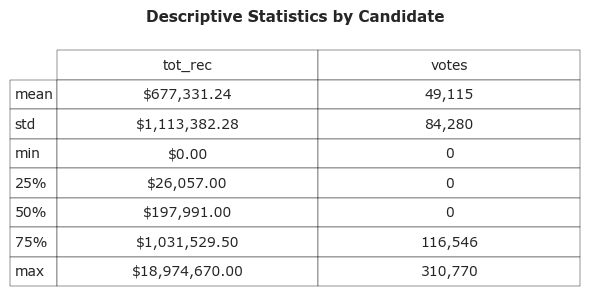

In [7]:
d = house[['tot_rec','votes']].describe().drop(index='count')

d['tot_rec'] = d['tot_rec'].apply(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
d['votes'] = d['votes'].astype(int).apply(lambda x: f"{x:,}" if isinstance(x, (int, float)) else x)

fig, ax = plt.subplots(figsize=(6, 3))

ax.axis('tight')
ax.axis('off')
plt.rcParams['font.family'] = 'Verdana'

table = ax.table(
    cellText=d.values,
    colLabels=d.columns,
    rowLabels=d.index,
    loc='center',
    cellLoc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
fig.suptitle('Descriptive Statistics by Candidate', fontsize=11, fontweight='bold')
fig.tight_layout()

plt.show()

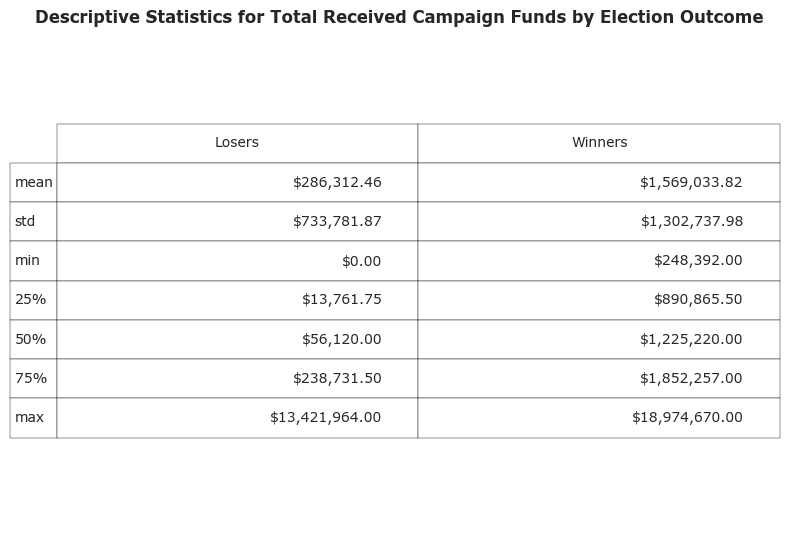

In [8]:
describe_losers = house[house['winner']==0]['tot_rec'].describe().apply(lambda x: f'${x:,.2f}' if isinstance(x, (int, float)) else x).drop('count', axis='index')

describe_winners = house[house['winner']==1]['tot_rec'].describe().apply(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x).drop('count', axis='index')

des = pd.concat([describe_losers, describe_winners], axis='columns')

fig, ax = plt.subplots()

plt.rcParams['font.family'] = 'Verdana'
ax.axis('off'), ax.axis('tight')
table = ax.table(cellText=des.values.tolist(), rowLabels=des.index, colLabels=['Losers','Winners'], loc='center')
table.scale(1,2)
plt.title('Descriptive Statistics for Total Received Campaign Funds by Election Outcome       ', fontweight='bold')

fig.tight_layout()

Text(0, 0.5, 'Count')

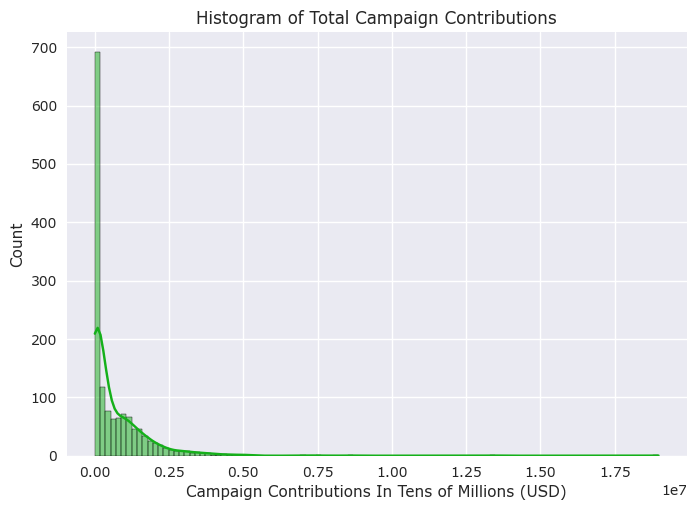

In [9]:
sns.histplot(data=house, x='tot_rec', kde=True, color='#15b01a')

plt.title('Histogram of Total Campaign Contributions')
plt.xlabel('Campaign Contributions In Tens of Millions (USD)')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

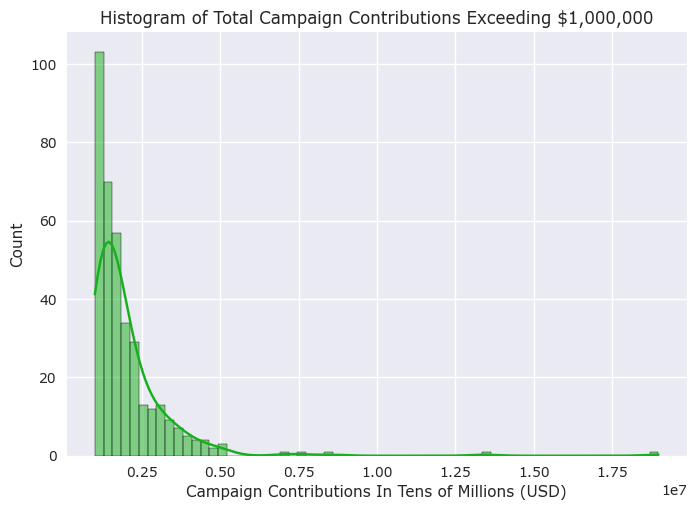

In [10]:
sns.histplot(data=house[house['tot_rec']>1000000], x='tot_rec', kde=True, color='#15b01a')

plt.title('Histogram of Total Campaign Contributions Exceeding $1,000,000')
plt.xlabel('Campaign Contributions In Tens of Millions (USD)')
plt.ylabel('Count')

([<matplotlib.axis.XTick at 0x199b2c74e10>,
 [Text(0, 0, 'Losers'), Text(1, 0, 'Winners')])

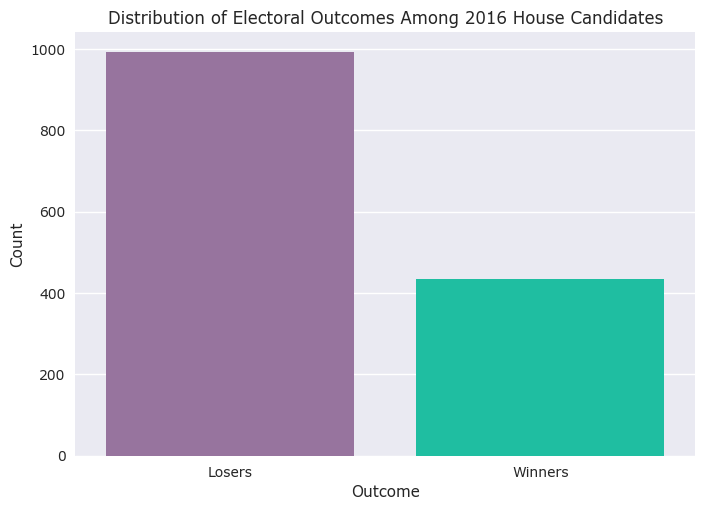

In [11]:
sns.countplot(data=house, x='winner', palette=['#9c6da5','#04d8b2'])

plt.title('Distribution of Electoral Outcomes Among 2016 House Candidates')
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.xticks(ticks=[0,1], labels=['Losers','Winners'])

([<matplotlib.axis.XTick at 0x199b2ccf890>,
 [Text(0, 0, 'Losers'), Text(1, 0, 'Winners')])

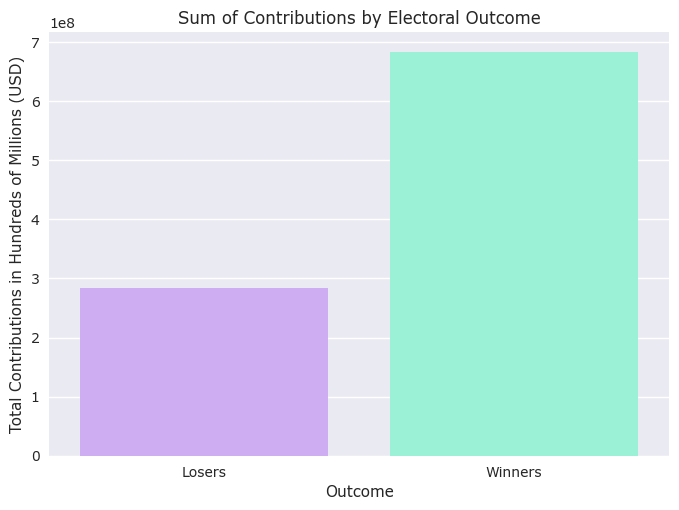

In [12]:
tot_rec_by_outcome = [house[house['winner']==0]['tot_rec'].sum(), house[house['winner']==1]['tot_rec'].sum()]

sns.barplot(x=[0,1], y=tot_rec_by_outcome, palette=['#cea2fd','#8cffdb'])

plt.title('Sum of Contributions by Electoral Outcome')
plt.xlabel('Outcome')
plt.ylabel('Total Contributions in Hundreds of Millions (USD)')
plt.xticks(ticks=[0,1], labels=['Losers','Winners'])

([<matplotlib.axis.XTick at 0x199b2d3b890>,
 [Text(0, 0, 'Loss'), Text(1, 0, 'Win')])

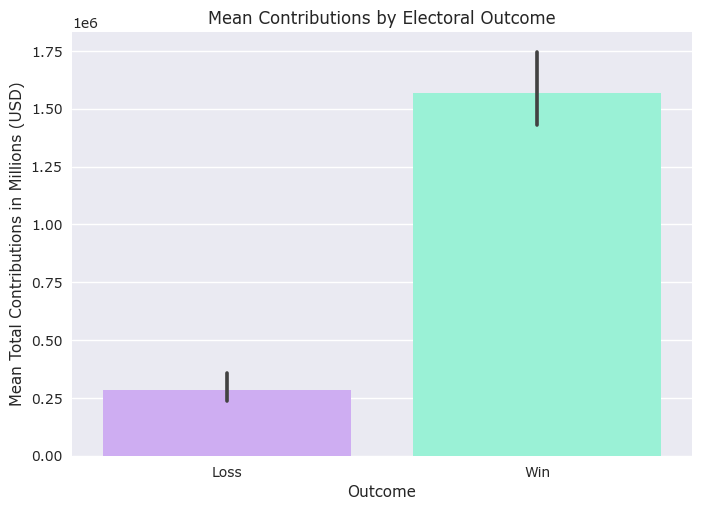

In [13]:
sns.barplot(data=house, x='winner', y='tot_rec', palette=['#cea2fd','#8cffdb'], errorbar=('ci',99))

plt.title('Mean Contributions by Electoral Outcome')
plt.xlabel('Outcome')
plt.ylabel('Mean Total Contributions in Millions (USD)')
plt.xticks(ticks=[0,1], labels=['Loss','Win'])

([<matplotlib.axis.XTick at 0x199b70d3610>,
 [Text(0, 0, 'Loss'), Text(1, 0, 'Win')])

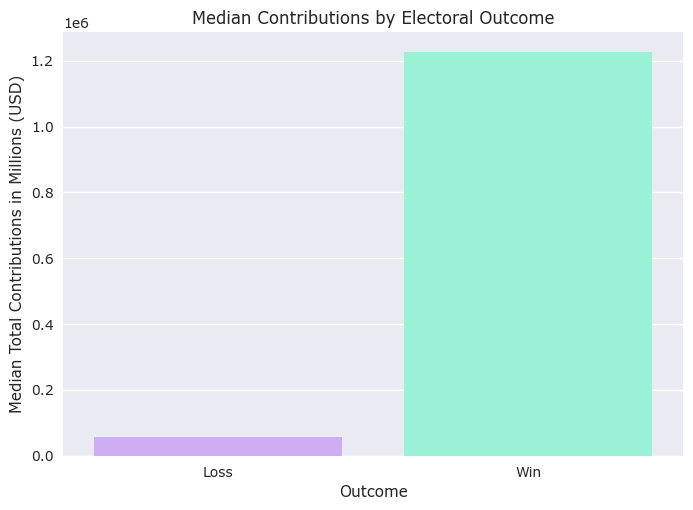

In [14]:

med_rec_by_outcome = [house[house['winner']==0]['tot_rec'].median(), house[house['winner']==1]['tot_rec'].median()]

sns.barplot(data=pd.DataFrame(med_rec_by_outcome), x=[0,1], y=med_rec_by_outcome, palette=['#cea2fd','#8cffdb'], errorbar=None)

plt.title('Median Contributions by Electoral Outcome')
plt.xlabel('Outcome')
plt.ylabel('Median Total Contributions in Millions (USD)')
plt.xticks(ticks=[0,1], labels=['Loss','Win'])


([<matplotlib.axis.XTick at 0x199b7142850>,
 [Text(0, 0, 'Losers'), Text(1, 0, 'Winners')])

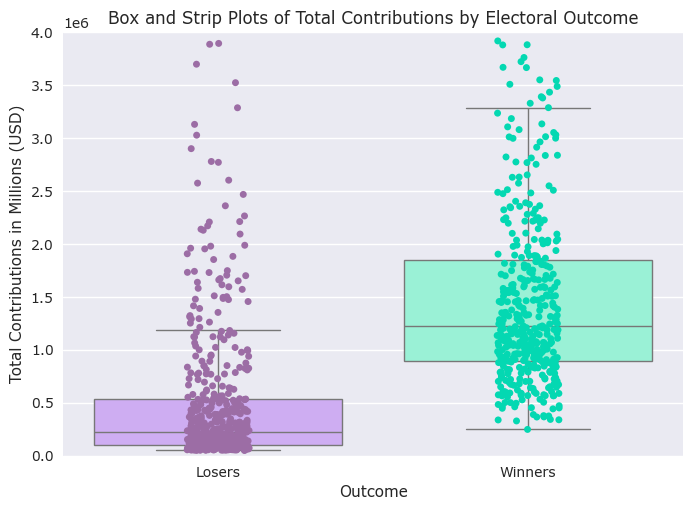

In [15]:

fig, ax = plt.subplots()

# Plot restricted to exclude 18 outliers (constituting approximately 1.3% of the dataset) exceeding $4,000,000 to produce 
# a more informative display
ax.set(ylim=(0, 4000000)) 

ax = sns.boxplot(data=house[house['tot_rec']>50000], x='winner', y='tot_rec', showfliers=False, palette=['#cea2fd','#8cffdb'])

ax = sns.stripplot(data=house[house['tot_rec']>50000], x='winner', y='tot_rec', palette=['#9c6da5','#04d8b2'])

plt.title('Box and Strip Plots of Total Contributions by Electoral Outcome')
plt.xlabel('Outcome')
plt.ylabel('Total Contributions in Millions (USD)')
plt.xticks(ticks=[0,1], labels=['Losers','Winners'])


#### Focus on the Two Ruling Parties

In [16]:
duopoly = house.query("party in ['Democrat', 'Republican']")

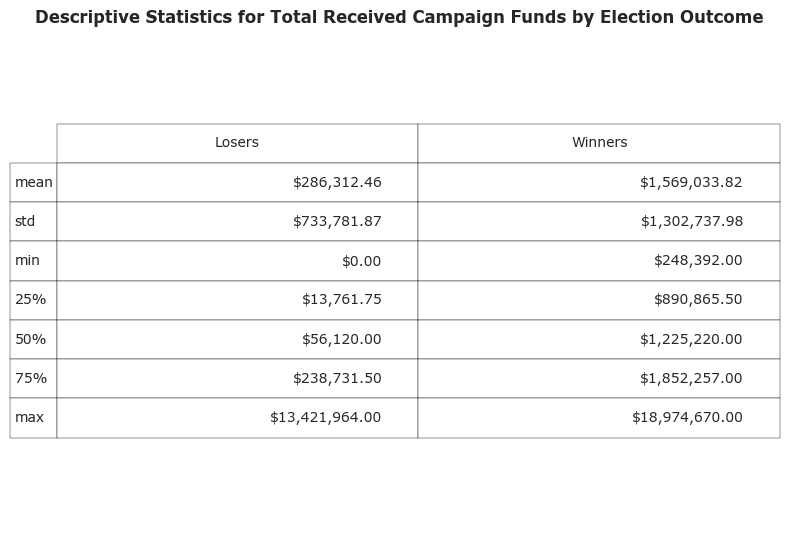

In [17]:
describe_losers = house[house['winner']==0]['tot_rec'].describe().apply(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x).drop('count', axis='index')

describe_winners = house[house['winner']==1]['tot_rec'].describe().apply(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x).drop('count', axis='index')

des = pd.concat([describe_losers, describe_winners], axis='columns')

fig, ax = plt.subplots()

plt.rcParams['font.family'] = 'Verdana'
ax.axis('off'), ax.axis('tight')
table = ax.table(cellText=des.values.tolist(), rowLabels=des.index, colLabels=['Losers','Winners'], loc='center')
table.scale(1,2)
plt.title('Descriptive Statistics for Total Received Campaign Funds by Election Outcome       ', fontweight='bold')

fig.tight_layout()

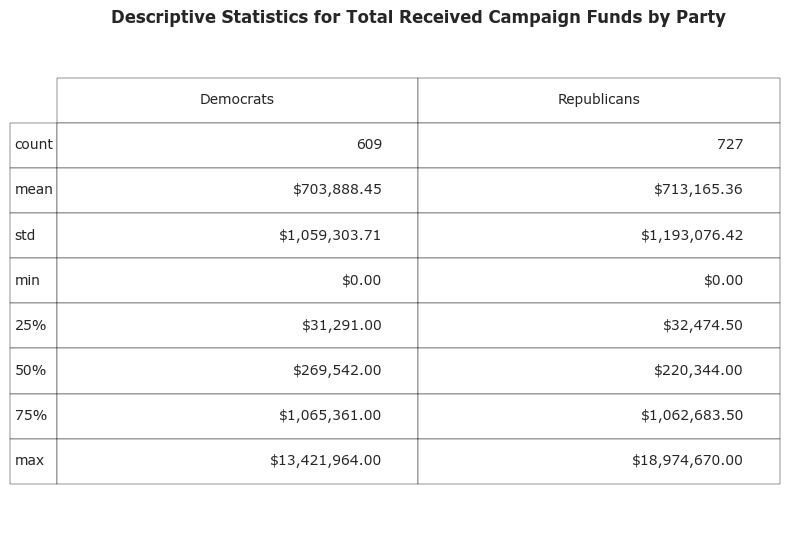

In [18]:
describe_dem = house[house['party']=='Democrat']['tot_rec'].describe().apply(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
describe_dem.loc['count'] = describe_dem.loc['count'].replace('$','').split('.')[0]

describe_rep = house[house['party']=='Republican']['tot_rec'].describe().apply(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
describe_rep.loc['count'] = describe_rep.loc['count'].replace('$','').split('.')[0]

des_party = pd.concat([describe_dem, describe_rep], axis='columns')

fig, ax = plt.subplots()

plt.rcParams['font.family'] = 'Verdana'
ax.axis('off'), ax.axis('tight')
table = ax.table(cellText=des_party.values.tolist(),rowLabels=des_party.index,colLabels=['Democrats','Republicans'],
                   loc='center')
table.scale(1,2.3)
plt.title('Descriptive Statistics for Total Received Campaign Funds by Party', fontweight='bold')

fig.tight_layout()

([<matplotlib.axis.XTick at 0x199b761fc50>,
 [Text(0, 0, 'Loss'), Text(1, 0, 'Win')])

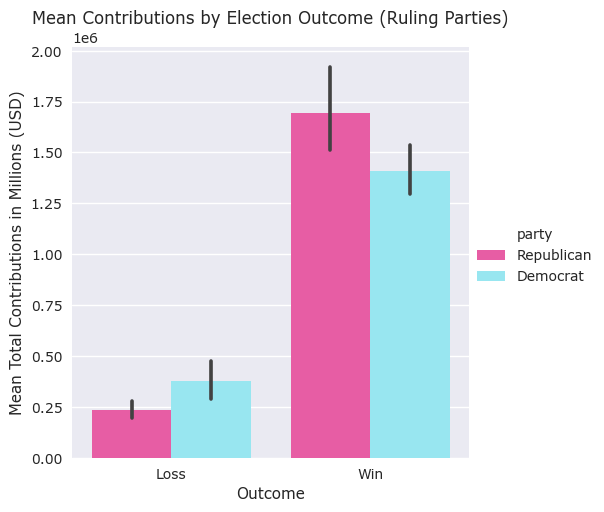

In [19]:

sns.catplot(data=duopoly, kind='bar', x='winner', y='tot_rec', hue='party', palette=['#fe46a5','#8af1fe'])

plt.title('Mean Contributions by Election Outcome (Ruling Parties)')
plt.xlabel('Outcome')
plt.ylabel('Mean Total Contributions in Millions (USD)')
plt.xticks(ticks=[0,1], labels=['Loss','Win'])


#### Association of Incumbency with Contributions and Outcome

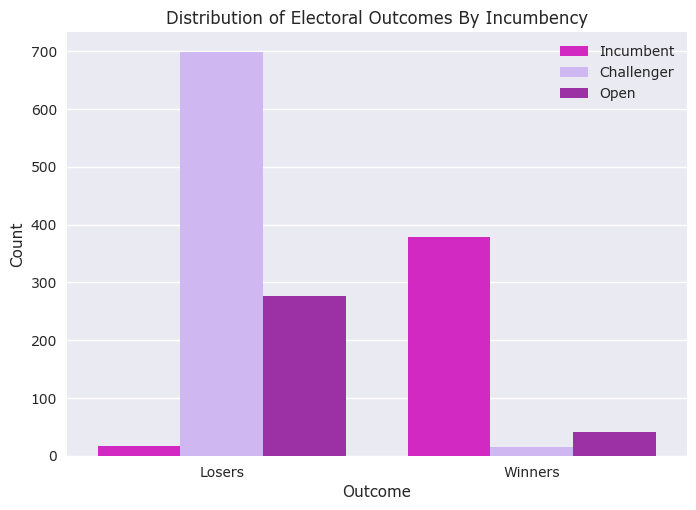

In [20]:
sns.countplot(data=house, x='winner', hue='inc', hue_order=['Incumbent','Challenger','Open'], palette=['#ed0dd9', '#ceaefa', '#ac1db8'])

plt.title('Distribution of Electoral Outcomes By Incumbency')
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.xticks(ticks=[0,1], labels=['Losers','Winners'])
plt.gca().legend().set_title('')

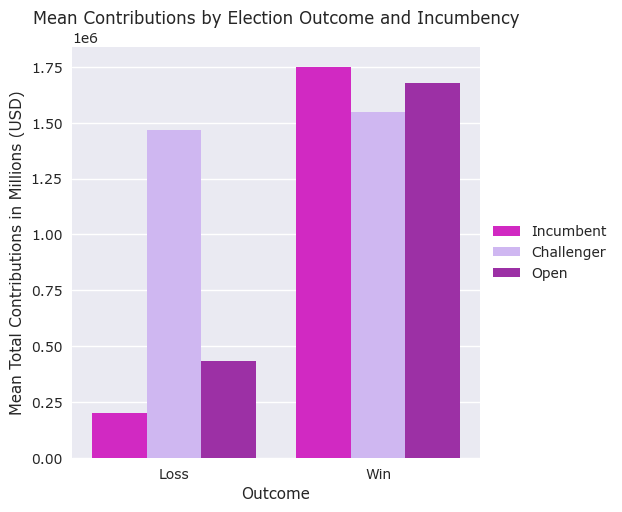

In [21]:
sns.catplot(data=house, kind='bar', x='winner', y='tot_rec', hue='inc', errorbar=None, 
            palette=['#ed0dd9', '#ceaefa', '#ac1db8'], legend=False)

plt.title('Mean Contributions by Election Outcome and Incumbency')
plt.xlabel('Outcome')
plt.ylabel('Mean Total Contributions in Millions (USD)')
plt.xticks(ticks=[0,1], labels=['Loss','Win'])
plt.legend(title='', labels=['Incumbent','Challenger','Open'], loc='center left', bbox_to_anchor=(1, 0.5))


([<matplotlib.axis.XTick at 0x199b75a0a50>,
 [Text(0, 0, 'Incumbent'), Text(1, 0, 'Challenger'), Text(2, 0, 'Open')])

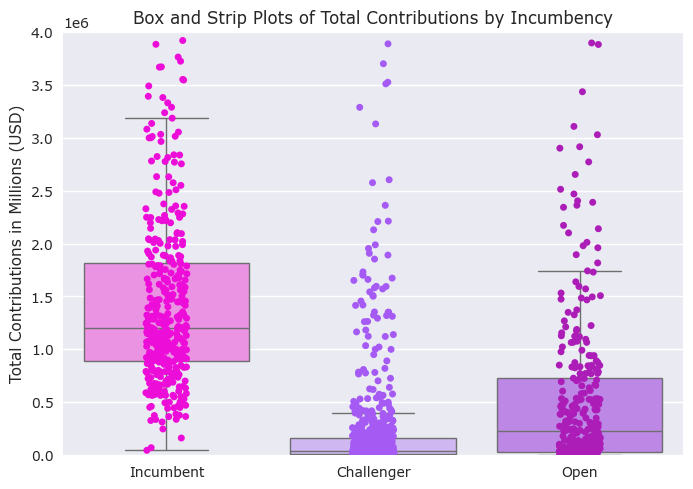

In [22]:

fig, ax = plt.subplots()

# Plot restricted to exclude 18 outliers (constituting approximately 1.3% of the dataset) exceeding $4,000,000 to produce 
# a more informative display
ax.set(ylim=(0, 4000000))

ax = sns.boxplot(data=house, x='inc', y='tot_rec', showfliers=False, palette=['#f984ef', '#ceaefa', '#bf77f6'])

ax = sns.stripplot(data=house, x='inc', y='tot_rec', palette=['#ed0dd9', '#a55af4', '#ac1db8'])

plt.title('Box and Strip Plots of Total Contributions by Incumbency')
plt.xlabel('')
plt.ylabel('Total Contributions in Millions (USD)')
plt.xticks(ticks=[0,1,2], labels=['Incumbent','Challenger','Open'])


([<matplotlib.axis.XTick at 0x199b8130e10>,
 [Text(0, 0, 'Losers'), Text(1, 0, 'Winners')])

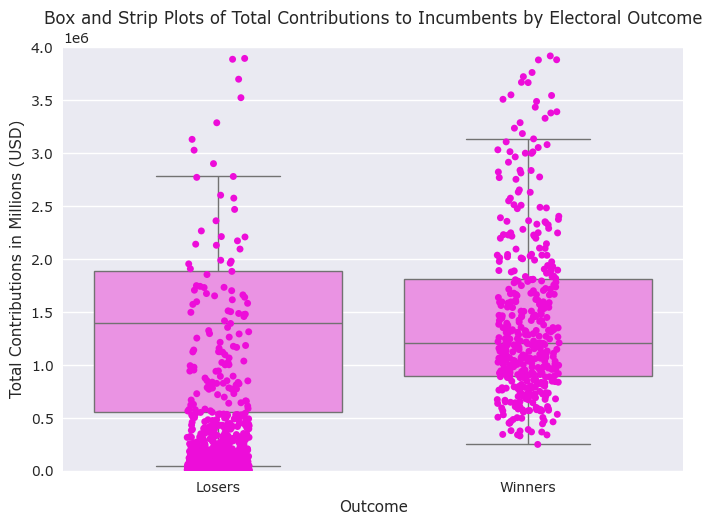

In [23]:

fig, ax = plt.subplots()

# Plot restricted to exclude 18 outliers (constituting approximately 1.3% of the dataset) exceeding $4,000,000 to produce 
# a more informative display
ax.set(ylim=(0, 4000000))

ax = sns.boxplot(data=house[house['inc']=='Incumbent'], x='winner', y='tot_rec', showfliers=False, palette=['#f984ef'])

ax = sns.stripplot(data=house, x='winner', y='tot_rec', palette=['#ed0dd9'])

plt.title('Box and Strip Plots of Total Contributions to Incumbents by Electoral Outcome')
plt.xlabel('Outcome')
plt.ylabel('Total Contributions in Millions (USD)')
plt.xticks(ticks=[0,1], labels=['Losers','Winners'])


([<matplotlib.axis.XTick at 0x199b83696d0>,
 [Text(0, 0, 'Losers'), Text(1, 0, 'Winners')])

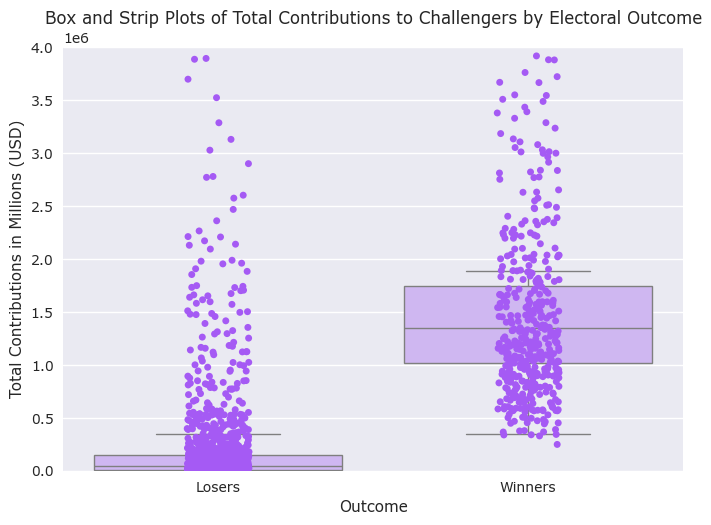

In [24]:

fig, ax = plt.subplots()

# Plot restricted to exclude 18 outliers (constituting approximately 1.3% of the dataset) exceeding $4,000,000 to produce 
# a more informative display
ax.set(ylim=(0, 4000000))

ax = sns.boxplot(data=house[house['inc']=='Challenger'], x='winner', y='tot_rec', showfliers=False, palette=['#ceaefa'])

ax = sns.stripplot(data=house, x='winner', y='tot_rec', palette=['#a55af4'])

plt.title('Box and Strip Plots of Total Contributions to Challengers by Electoral Outcome')
plt.xlabel('Outcome')
plt.ylabel('Total Contributions in Millions (USD)')
plt.xticks(ticks=[0,1], labels=['Losers','Winners'])



([<matplotlib.axis.XTick at 0x199b83d5f90>,
 [Text(0, 0, 'Losers'), Text(1, 0, 'Winners')])

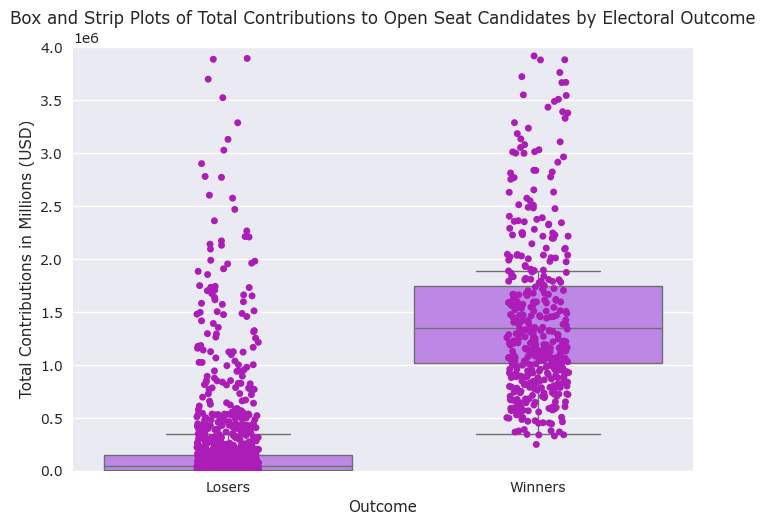

In [25]:

fig, ax = plt.subplots()

# Plot restricted to exclude 18 outliers (constituting approximately 1.3% of the dataset) exceeding $4,000,000 to produce 
# a more informative display
ax.set(ylim=(0, 4000000))

ax = sns.boxplot(data=house[house['inc']=='Challenger'], x='winner', y='tot_rec', showfliers=False, palette=['#bf77f6'])

ax = sns.stripplot(data=house, x='winner', y='tot_rec', palette=['#ac1db8'])

plt.title('Box and Strip Plots of Total Contributions to Open Seat Candidates by Electoral Outcome')
plt.xlabel('Outcome')
plt.ylabel('Total Contributions in Millions (USD)')
plt.xticks(ticks=[0,1], labels=['Losers','Winners'])


### Parametric Analysis

In [26]:
lose_rec = house[house['winner']==0]['tot_rec']

win_rec = house[house['winner']==1]['tot_rec']


#### Check for Normality and Homoskedasticity 


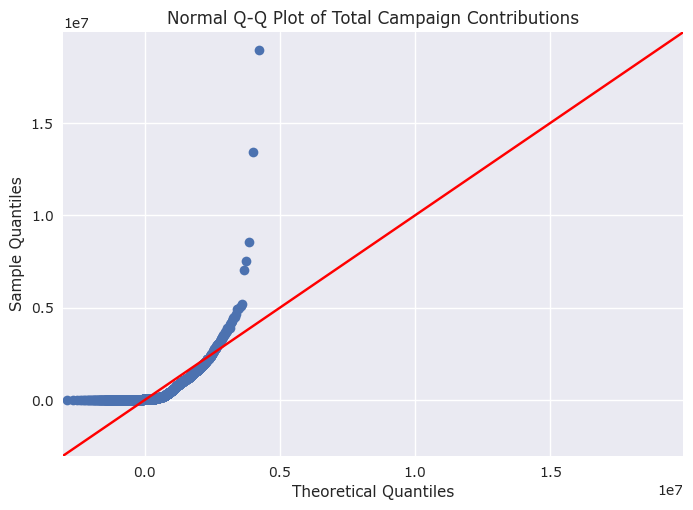

In [27]:
pp = sm.ProbPlot(house['tot_rec'], loc=np.mean(house['tot_rec']), scale=np.std(house['tot_rec']))

ax = pp.qqplot(line='45')

plt.title('Normal Q-Q Plot of Total Campaign Contributions')

plt.show()

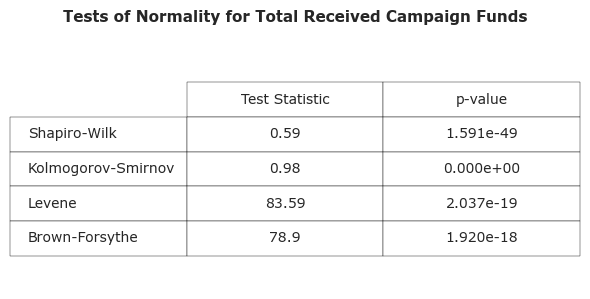

In [28]:
shapiro_wilk = list(map(str, list(stats.shapiro(house['tot_rec']))))

kolmogorov_smirnov = list(map(str, list(stats.kstest(house['tot_rec'], 'norm'))))

levene = list(map(str, list(stats.levene(lose_rec, win_rec, center='mean'))))

brown_forsythe = list(map(str, list(stats.levene(lose_rec, win_rec, center='median'))))

tests = [shapiro_wilk, kolmogorov_smirnov, levene, brown_forsythe] 

test_names = ['Shapiro-Wilk','Kolmogorov-Smirnov', 'Levene','Brown-Forsythe']

test_df = pd.DataFrame(data=tests, index=test_names, columns=['Test Statistic', 'p-value']).astype(float)

test_df['Test Statistic'] = test_df['Test Statistic'].round(2)

test_df['p-value'] = test_df['p-value'].apply(lambda x: f"{x:.3e}")

fig, ax = plt.subplots(figsize=(6, 3))

ax.axis('tight')
ax.axis('off')
plt.rcParams['font.family'] = 'Verdana'

table = ax.table(
    cellText=test_df.values,
    colLabels=test_df.columns,
    rowLabels=test_df.index,
    loc='center',
    cellLoc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
fig.suptitle('Tests of Normality for Total Received Campaign Funds', fontsize=11, fontweight='bold')
fig.tight_layout()

plt.show()

### Correlational Analysis and Non-Parametric Comparison Testing

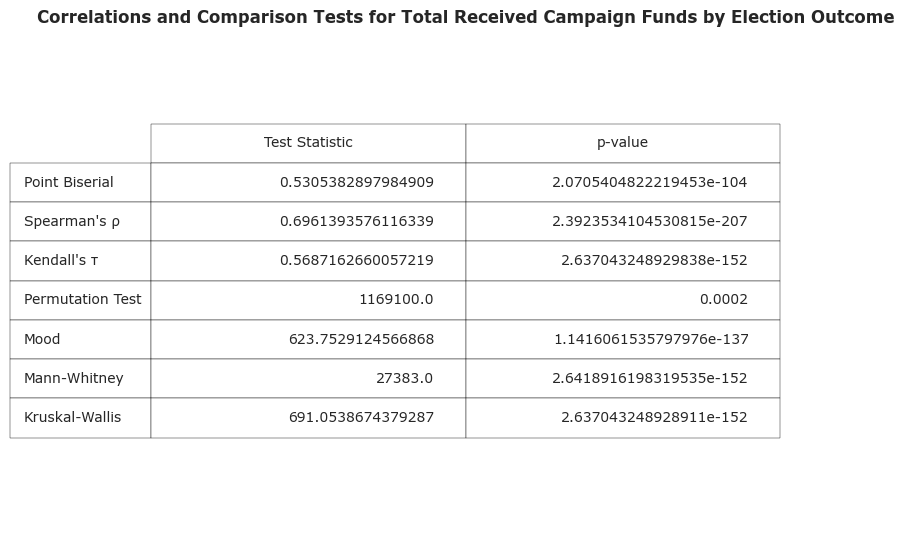

In [29]:
pearson = list(map(str, list(stats.pearsonr(house['tot_rec'],house['winner']))))

spearman = list(map(str, list(stats.spearmanr(house['tot_rec'],house['winner']))))

kendall = list(map(str, list(stats.kendalltau(house['tot_rec'],house['winner']))))

def statistic(x, y, axis):
    return np.median(x, axis=axis) - np.median(y, axis=axis)

pt = stats.permutation_test([win_rec, lose_rec], statistic)

perm = [pt.statistic, pt.pvalue]

mood = list(map(str, list(stats.median_test(lose_rec, win_rec))))[0:2]

mann_whitney = list(map(str, list(stats.mannwhitneyu(lose_rec, win_rec))))
               
kruskal_wallis = list(map(str, list(stats.kruskal(lose_rec,win_rec))))

tests = [pearson, spearman, kendall, perm, mood, mann_whitney, kruskal_wallis]

test_names = ["Point Biserial", "Spearman's ρ", "Kendall's τ", 'Permutation Test', 'Mood', 'Mann-Whitney','Kruskal-Wallis']

fig, ax = plt.subplots()

plt.rcParams['font.family'] = 'Verdana'
ax.axis('off'), ax.axis('tight')
table = ax.table(cellText=tests, colLabels=['Test Statistic','p-value'], rowLabels=test_names, loc='center')
table.scale(1,2)
plt.title('Correlations and Comparison Tests for Total Received Campaign Funds by Election Outcome', fontweight='bold')
fig.tight_layout()


### Sample Proportions and Tests of Independence

#### Proportion of Wins by Incumbency

In [30]:
h_inc = house[house['inc']=='Incumbent']

h_chal = house[house['inc']=='Challenger']
               
h_open = house[house['inc']=='Open']

p_inc = round(np.shape(h_inc[h_inc['winner']==1])[0] / np.shape(h_inc)[0], 3)

p_chal = round(np.shape(h_chal[h_chal['winner']==1])[0] / np.shape(h_chal)[0], 3)

p_open = round(np.shape(h_open[h_open['winner']==1])[0] / np.shape(h_open)[0], 3)

print('Proportion of wins among incumbents:', p_inc)
print('Proportion of wins among challengers:', p_chal)
print('Proportion of wins among open contenders:', p_open)

Proportion of wins among incumbents: 0.957
Proportion of wins among challengers: 0.021
Proportion of wins among open contenders: 0.129


#### Proportion of Wins by Incumbency Among All Candidates

In [31]:

h_inc = house[house['inc']=='Incumbent']

h_chal = house[house['inc']=='Challenger']
               
h_open = house[house['inc']=='Open']

p_inc = round(np.shape(h_inc[h_inc['winner']==1])[0] / np.shape(house)[0], 3)

p_chal = round(np.shape(h_chal[h_chal['winner']==1])[0] / np.shape(house)[0], 3)

p_open = round(np.shape(h_open[h_open['winner']==1])[0] / np.shape(house)[0], 3)

print('Proportion of wins by incumbents:', p_inc)
print('Proportion of wins by challengers:', p_chal)
print('Proportion of wins by open contenders:', p_open)

Proportion of wins by incumbents: 0.266
Proportion of wins by challengers: 0.011
Proportion of wins by open contenders: 0.029


#### Proportion of Wins by Incumbency Among All Winners

In [32]:

h_inc = house[house['inc']=='Incumbent']

h_chal = house[house['inc']=='Challenger']
               
h_open = house[house['inc']=='Open']

p_inc = round(np.shape(h_inc[h_inc['winner']==1])[0] / np.shape(house[house['winner']==1])[0], 3)

p_chal = round(np.shape(h_chal[h_chal['winner']==1])[0] / np.shape(house[house['winner']==1])[0], 3)

p_open = round(np.shape(h_open[h_open['winner']==1])[0] / np.shape(house[house['winner']==1])[0], 3)

print('Proportion of incumbents among winners:', p_inc)
print('Proportion of challengers among winners:', p_chal)
print('Proportion of open contenders among winners:', p_open)

Proportion of incumbents among winners: 0.871
Proportion of challengers among winners: 0.034
Proportion of open contenders among winners: 0.094


#### Tests of Idependence

In [33]:
observed = pd.crosstab(index=house['inc'], columns=house['winner'])

display(observed)

winner,0,1
inc,,
Challenger,698,15
Incumbent,17,379
Open,277,41


In [34]:
expected = pd.DataFrame(stats.chi2_contingency(observed).expected_freq, index=['Challenger','Incumbent','Open'],
             columns=['Loss','Win']).round().astype(int)

display(expected)

,Loss,Win
Challenger,496,217
Incumbent,275,121
Open,221,97


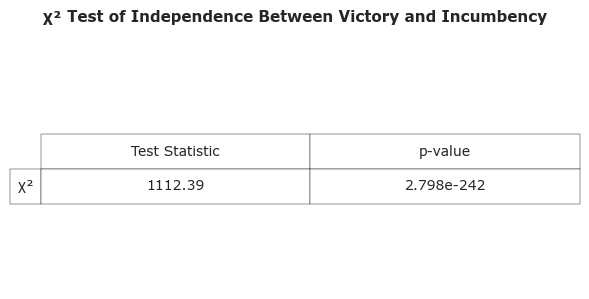

In [35]:
chi2 = list(map(str, [stats.chi2_contingency(observed).statistic, stats.chi2_contingency(observed).pvalue]))

tests = [chi2]

test_names = [" χ² "]

test_df = pd.DataFrame(data=tests, index=test_names, columns=['Test Statistic', 'p-value']).astype(float)

test_df['Test Statistic'] = test_df['Test Statistic'].round(2)

test_df['p-value'] = test_df['p-value'].apply(lambda x: f"{x:.3e}")

fig, ax = plt.subplots(figsize=(6, 3))

ax.axis('tight')
ax.axis('off')
plt.rcParams['font.family'] = 'Verdana'

table = ax.table(
    cellText=test_df.values,
    colLabels=test_df.columns,
    rowLabels=test_df.index,
    loc='center',
    cellLoc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
fig.suptitle('χ² Test of Independence Between Victory and Incumbency', fontsize=11, fontweight='bold')
fig.tight_layout()

plt.show()


### Covariate-Adjusted Logistic Regression Analysis

We now wish to determine the size of the effect of campaign funds in determining electoral outcomes while controlling for the confounding variable of incumbency. As the categorical dependent variable of electoral victory or loss $W$ is not amenable to such an analysis by means of, e.g., one-way ANCOVA, we make use of the Generalized Linear Model (GLM) with logit link

$$\text{logit}(P[W=1]) = \beta_0 + \beta_1 C + \beta_2 I$$

where (as noted above) the dichotomous response variable $W$ denotes electoral victory or loss; the continous explanatory variable $C$ denotes total campaign contributions; and the categorical covariate $I$ denotes incumbency, with $\beta_k$ for $k\in\{0,1,2\}$ denoting the affine model parameters.

However, as noted during Data Description and Visualization, there exists a substantial imbalance between the binary outcomes of $W$ in this dataset, which could limit the goodness of fit of our model. After a preliminary application of the model to the untrimmed and untransformed data, measures are subsequently taken to address this imbalance, which could introduce bias in our parameter estimates towards the majority response category (the losers).

In [64]:
inc_map = {'Open':1,'Challenger':2, 'Incumbent':3}

print('Winner count of untrimmed data:', np.shape(house[house['winner']==1])[0])
print('Loser count of untrimmed data:', np.shape(house[house['winner']==0])[0])
print('Incumbency counts:\n', house['inc'].value_counts().reindex(['Incumbent', 'Challenger', 'Open'], fill_value=0).rename_axis('') )

print()

house['inc'] = house['inc'].map(inc_map)

model = sm.Logit(house['winner'], house[['tot_rec', 'inc']]) 
result = model.fit()

print(result.summary())
print()

marginal_effects = result.get_margeff()
print(marginal_effects.summary())

house['inc'] = house['inc'].map({v:k for k,v in inc_map.items()})

Winner count of untrimmed data: 435
Loser count of untrimmed data: 992
Incumbency counts:
 
Incumbent     396
Challenger    713
Open          318
Name: count, dtype: int64

Optimization terminated successfully.
         Current function value: 0.555953
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 winner   No. Observations:                 1427
Model:                          Logit   Df Residuals:                     1425
Method:                           MLE   Df Model:                            1
Date:                Sat, 28 Dec 2024   Pseudo R-squ.:                 0.09587
Time:                        19:03:02   Log-Likelihood:                -793.34
converged:                       True   LL-Null:                       -877.47
Covariance Type:            nonrobust   LLR p-value:                 1.783e-38
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------

By virtue of the low p-values and decent pseudo-$R^2$ value $R_{\text{McFadden}}^2 = 0.2737 \in [0.2,0.4]$ indicative of good model fit, the foregoing analysis reveals strong evidence for rejection of the null hypothesis that total received campaign contributions have no effect on electoral outcome after controlling for incumbency. In particular, the present analysis yields a conditional odds ratio (OR) for $C$ of 

$$ e^{\beta_1} \approx 1.00000164,$$

such that an additional $100,000.00 in campaign contributions multiplies a candidate's odds of victory by 

$$\exp(100000 \cdot 0.00000164) \approx 1.178,$$

i.e., **an additional $100,000.00 in campaign contributions increases a candidate's odds of victory by about 17.8% after controlling for the potentially confounding variable of candidate incumbency**.

We also make note in passing of the counterintuitive negative coefficient $\beta_2$ associated with incumbency $I$ despite having arranged the incumbency dummy variables to correlate positively with the association of $I$ with $W$, which may be attributable to potential multicollinearity between $C$ and $I$, category imbalance within $I$ (noted above during Data Inspection and Visualization), or, most interestingly, possible evidence of a small inverse association between odds of victory and incumbency after controlling for total campaign contributions. In order to elucidate this issue, the respective variance inflation factors for $C$ and $I$ are computed below, and the data trimming and upsampling approaches which follow attempt to compensate for the imbalances in both $W$ and $I$.

#### Variance Inflation Factor (VIF)

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

inc_map = {'Open':1,'Challenger':2, 'Incumbent':3}

house['inc'] = house['inc'].map(inc_map)

X = house.copy(deep=True)
X = X[['tot_rec','inc']]
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

house['inc'] = house['inc'].map({v:k for k,v in inc_map.items()})

  Variable       VIF
0  tot_rec  1.516032
1      inc  1.516032


As can be seen from the above output, the VIFs associated with both variables are quite low, indicating low multicollinearity. In order to rule out class imbalance, we proceed to (rather arbitrarily) trim the data to bring both $I$ and $W$ into greater balance:

#### Ad Hoc Trim

It so happens that precisely 435 losers received campaign contributions equal to or exceeding $77,000.00. Although it is doubtless distortive and ordinarily highly ill-advised to trim data at an arbitrary cutoff value, doing so brings $W$ into precise balance and significantly improves the imbalance of $I$. Moreover, other attempts at trimming the data using, e.g., 1.5*IQR did not yield any such advantages. It should also be stressed that such imbalances are practically unavoidable without drastic and potentially distortive corrective measures in that 1) A fixed number of contenders (435) are ordinarily guaranteed to win any given house race, whereas the number of losing competitors is potentially infinite, introducing an inevitable imbalance in $W$ of a priori unlimited magnitude; and 2) The number of incumbents is similarly numerically limited. Finally, it must be emphasized that this trimming procedure was undertaken **solely** to ascertain to what extent the imbalances in $W$ and $I$ might have contributed to the unexpected negative estimate for $\beta_2$ obtained above, and **not** to substitute for the foregoing analysis of the whole dataset.

In [38]:
cutoff = 77000

house_trim = house[house['tot_rec']>cutoff]

print('Cutoff:', f'${cutoff:.2f}')
print('Winner count after trim:', np.shape(house_trim[house_trim['winner']==1])[0])
print('Loser count after trim:', np.shape(house_trim[house_trim['winner']==0])[0])
print()

house_trim['inc'] = house_trim['inc'].map(inc_map)

model = sm.Logit(house_trim['winner'], house_trim[['tot_rec', 'inc']]) 
result = model.fit()

print(result.summary())
print()

marginal_effects = result.get_margeff()
print(marginal_effects.summary())

house_trim['inc'] = house_trim['inc'].map({v:k for k,v in inc_map.items()})

Cutoff: $77000.00
Winner count after trim: 435
Loser count after trim: 435

Optimization terminated successfully.
         Current function value: 0.643595
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 winner   No. Observations:                  870
Model:                          Logit   Df Residuals:                      868
Method:                           MLE   Df Model:                            1
Date:                Sat, 28 Dec 2024   Pseudo R-squ.:                 0.07149
Time:                        18:59:44   Log-Likelihood:                -559.93
converged:                       True   LL-Null:                       -603.04
Covariance Type:            nonrobust   LLR p-value:                 1.610e-20
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
tot_rec     4.917e-07   9.38e-08

#### Outlier Trim

In [39]:
h = house

q1 = np.quantile(h['tot_rec'], .25)

q3 = np.quantile(h['tot_rec'], .75)

iqr = stats.iqr(h['tot_rec'])
    
house_trim = h[house['tot_rec'] > q1 - 1.5 * iqr][house['tot_rec'] < q3 + 1.5 * iqr]

print('Winner count after trim:', np.shape(house_trim[house_trim['winner']==1])[0])
print('Loser count after trim:', np.shape(house_trim[house_trim['winner']==0])[0])
print()

house_trim['inc'] = house_trim['inc'].map(inc_map)

model = sm.Logit(house_trim['winner'], house_trim[['tot_rec', 'inc']]) 
result = model.fit()

print(result.summary())
print()

marginal_effects = result.get_margeff()
print(marginal_effects.summary())

house_trim['inc'] = house_trim['inc'].map({v:k for k,v in inc_map.items()})

Winner count after trim: 379
Loser count after trim: 977

Optimization terminated successfully.
         Current function value: 0.499901
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 winner   No. Observations:                 1356
Model:                          Logit   Df Residuals:                     1354
Method:                           MLE   Df Model:                            1
Date:                Sat, 28 Dec 2024   Pseudo R-squ.:                  0.1563
Time:                        18:59:44   Log-Likelihood:                -677.87
converged:                       True   LL-Null:                       -803.40
Covariance Type:            nonrobust   LLR p-value:                 1.517e-56
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
tot_rec     2.609e-06   1.53e-07     17.092      0

#### SMOTE

In [70]:
from imblearn.over_sampling import SMOTE

house['inc'] = house['inc'].map(inc_map)

X = house[['tot_rec', 'inc']]
y = house['winner']

smote = SMOTE(random_state=137)
X_smote, y_smote = smote.fit_resample(X, y)

house_smote = pd.DataFrame(X_smote, columns=X.columns)
house_smote['winner'] = y_smote

print('Winner count after resampling:', np.shape(house_smote[house_smote['winner']==1])[0])
print('Loser count after resampling:', np.shape(house_smote[house_smote['winner']==0])[0])
house_smote['inc'] = house_smote['inc'].map({v:k for k,v in inc_map.items()})
print('Incumbency counts:\n', house_smote['inc'].value_counts().reindex(['Incumbent', 'Challenger', 'Open'], fill_value=0).rename_axis('') )
house_smote['inc'] = house_smote['inc'].map(inc_map)
print('')
print()

model = sm.Logit(house_smote['winner'], house_smote[['tot_rec', 'inc']]) 
result = model.fit(cov_type='HC3')

print(result.summary())
print()

marginal_effects = result.get_margeff()
print(marginal_effects.summary())

house['inc'] = house['inc'].map({v:k for k,v in inc_map.items()})

Winner count after resampling: 992
Loser count after resampling: 992
Incumbency counts:
 
Incumbent     826
Challenger    785
Open          373
Name: count, dtype: int64


Optimization terminated successfully.
         Current function value: 0.517789
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 winner   No. Observations:                 1984
Model:                          Logit   Df Residuals:                     1982
Method:                           MLE   Df Model:                            1
Date:                Sat, 28 Dec 2024   Pseudo R-squ.:                  0.2530
Time:                        19:06:34   Log-Likelihood:                -1027.3
converged:                       True   LL-Null:                       -1375.2
Covariance Type:                  HC3   LLR p-value:                2.424e-153
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------

### Assessment of Linear Separability with Single-Layer Perceptron

#### Untransformed Data

In [41]:
from sklearn.linear_model import Perceptron

perceptron = Perceptron(random_state=137)

X = house[['inc','tot_rec']]

X = pd.get_dummies(X)

y = house['winner'].astype(int)

perceptron.fit(X, y)

Perceptron(random_state=137)

              precision    recall  f1-score   support

           0       0.03      1.00      0.06        30
           1       1.00      0.31      0.47      1397

    accuracy                           0.33      1427
   macro avg       0.52      0.66      0.27      1427
weighted avg       0.98      0.33      0.47      1427



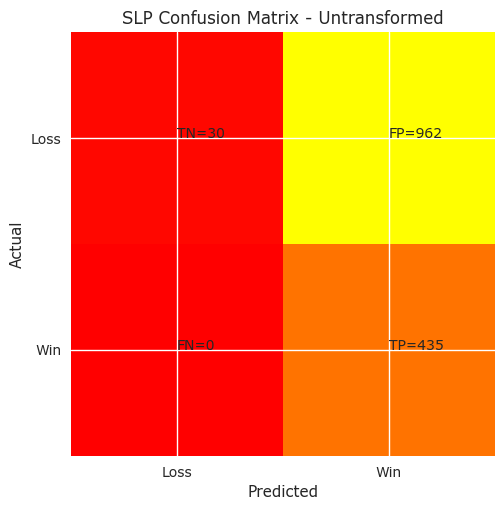

In [42]:
matrix = confusion_matrix(y, perceptron.predict(X))
 
plt.clf() 
plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.autumn)

plt.title('SLP Confusion Matrix - Untransformed')
plt.ylabel('Actual')
plt.xlabel('Predicted')

target = ['Loss','Win']
ticks = [0,1]
plt.xticks(ticks, target)
plt.yticks(ticks, target)

labels = [['TN','FP'], ['FN', 'TP']]
  
for j in range(2):
    for k in range(2):
        plt.text(k,j, str(labels[j][k]) + '=' + str(matrix[j][k]))
        
print(classification_report(perceptron.predict(X), y))
plt.show()

#### Rescaled Data - MinMaxScaler

              precision    recall  f1-score   support

           0       0.98      0.95      0.96      1018
           1       0.89      0.94      0.91       409

    accuracy                           0.95      1427
   macro avg       0.93      0.95      0.94      1427
weighted avg       0.95      0.95      0.95      1427



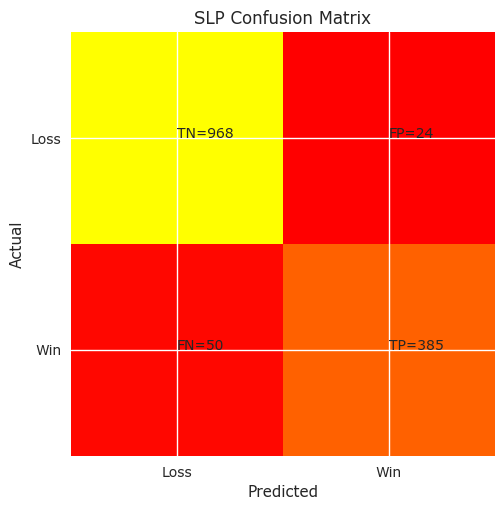

In [43]:
from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler()

X_mm = minmax.fit_transform(X)

perceptron.fit(X_mm, y)

matrix = confusion_matrix(y, perceptron.predict(X_mm))

plt.clf() 
plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.autumn)

plt.title('SLP Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

target = ['Loss','Win']
ticks = [0,1]
plt.xticks(ticks, target)
plt.yticks(ticks, target)

labels = [['TN','FP'], ['FN', 'TP']]
  
for j in range(2):
    for k in range(2):
        plt.text(k,j, str(labels[j][k]) + '=' + str(matrix[j][k]))

print(classification_report(perceptron.predict(X_mm), y))
plt.show()

#### RobustScaler

              precision    recall  f1-score   support

           0       0.99      0.90      0.94      1092
           1       0.74      0.96      0.83       335

    accuracy                           0.91      1427
   macro avg       0.86      0.93      0.89      1427
weighted avg       0.93      0.91      0.91      1427



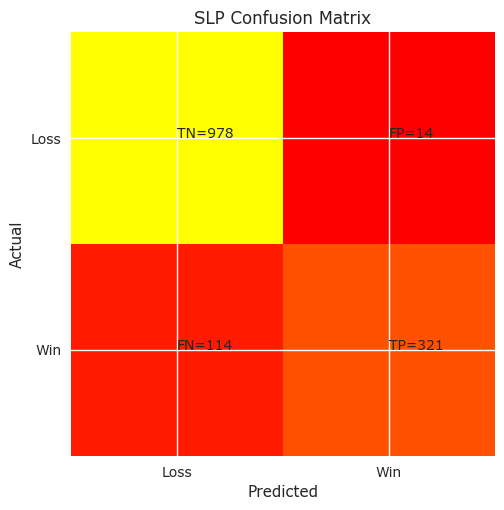

In [44]:
from sklearn.preprocessing import RobustScaler

robust = RobustScaler()

X_rs = robust.fit_transform(X)

perceptron.fit(X_rs, y)

matrix = confusion_matrix(y, perceptron.predict(X_rs))

plt.clf() 
plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.autumn)

plt.title('SLP Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

target = ['Loss','Win']
ticks = [0,1]
plt.xticks(ticks, target)
plt.yticks(ticks, target)

labels = [['TN','FP'], ['FN', 'TP']]
  
for j in range(2):
    for k in range(2):
        plt.text(k,j, str(labels[j][k]) + '=' + str(matrix[j][k]))

print(classification_report(perceptron.predict(X_rs), y))
plt.show()

### Algorithmic Classification and Outcome Prediction

In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

In [46]:
def optimizer(algorithm, param_grid, X, y):
    
    alg = algorithm
    
    gs = GridSearchCV(algorithm, param_grid).fit(X, y)
    
    alg_opt = alg.set_params(**gs.best_params_)
    
    return alg_opt

#### Preprocessing

In [47]:
from sklearn.model_selection import train_test_split

X = house[['inc','tot_rec']]

X = pd.get_dummies(X)

y = house['winner'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=137)

minmax = MinMaxScaler()

X_train_mm = minmax.fit_transform(X_train)

X_test_mm = minmax.transform(X_test)

#### Logistic Regression

In [48]:

log_grid =  {'C':[0.001,0.01,0.1,1,5,7.5,10], 'class_weight':[None,'balanced'], 'penalty':['l1','l2']}

logreg = optimizer(LogisticRegression(), log_grid, X_train_mm, y_train)

logreg.fit(X_train_mm, y_train)

print(logreg.coef_, logreg.intercept_)


[[ 0.01571814 -0.15115516  0.19260032 -0.04143062]] [-0.0218433]


In [49]:
print(classification_report(logreg.predict(X_test_mm), y_test))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97       327
           1       0.88      0.96      0.92       102

    accuracy                           0.96       429
   macro avg       0.94      0.96      0.95       429
weighted avg       0.96      0.96      0.96       429



Text(0.5, 1.0, 'Logistic Regression Confusion Matrix')

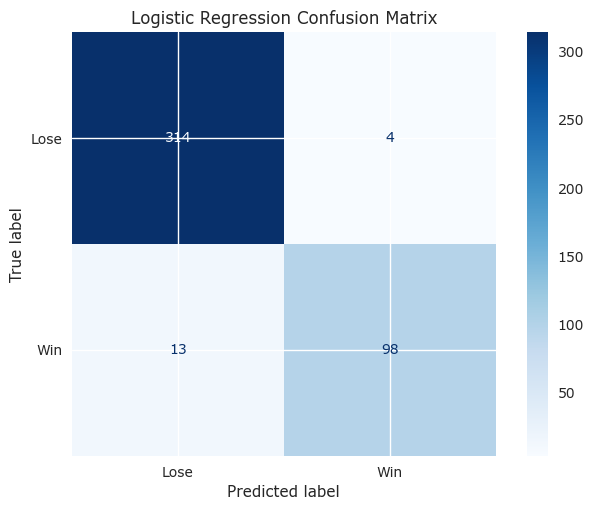

In [50]:

cm_logreg = confusion_matrix(y_test, logreg.predict(X_test_mm), labels=logreg.classes_)

ConfusionMatrixDisplay(confusion_matrix=cm_logreg, display_labels=['Lose','Win']).plot(cmap=plt.cm.Blues)

plt.title('Logistic Regression Confusion Matrix')


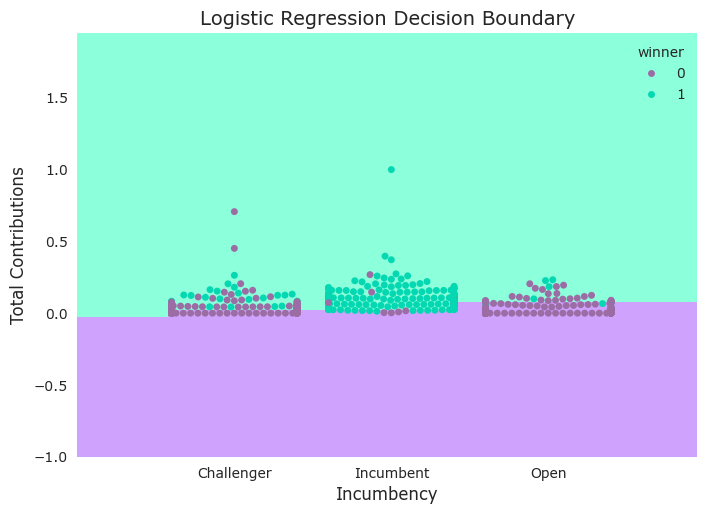

In [51]:

from matplotlib.colors import ListedColormap

H = house.copy(deep=True)

H['inc'] = H['inc'].map({'Incumbent':1,'Challenger':2,'Open':0})

H['tot_rec'] = ( H['tot_rec'] - min(H['tot_rec']) ) / ( max(H['tot_rec']) - min(H['tot_rec']) )

X = H[['inc','tot_rec']]

y = H['winner']

h = .05  

cmap_light = ListedColormap(['#cea2fd','#8cffdb'])
cmap_bold = ListedColormap(['#9c6da5','#04d8b2'])

clf = LogisticRegression(C=5, class_weight='balanced', penalty='l2')
clf.fit(X, y)

x_min, x_max = X['inc'].min() - 1, X['inc'].max() + 1
y_min, y_max = X['tot_rec'].min() - 1, X['tot_rec'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

sns.swarmplot(data=H, x='inc', y='tot_rec', hue='winner', palette=['#9c6da5','#04d8b2'])
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title('Logistic Regression Decision Boundary', fontsize=14)
plt.xticks(ticks=[0,1,2], labels=['Challenger','Incumbent','Open'])
plt.xlabel('Incumbency', fontsize=12)
plt.ylabel('Total Contributions', fontsize=12)

plt.show()


#### K-Nearest Neighbor

In [52]:

knn_grid = {'n_neighbors':range(1,100)}

knn = optimizer(KNeighborsClassifier(), knn_grid, X_train_mm, y_train)

knn.fit(X_train_mm, y_train)


KNeighborsClassifier(n_neighbors=12)

In [53]:

print(classification_report(y_test, knn.predict(X_test_mm)))


              precision    recall  f1-score   support

           0       0.98      0.96      0.97       318
           1       0.90      0.94      0.92       111

    accuracy                           0.96       429
   macro avg       0.94      0.95      0.94       429
weighted avg       0.96      0.96      0.96       429



Text(0.5, 1.0, 'k-NN Confusion Matrix')

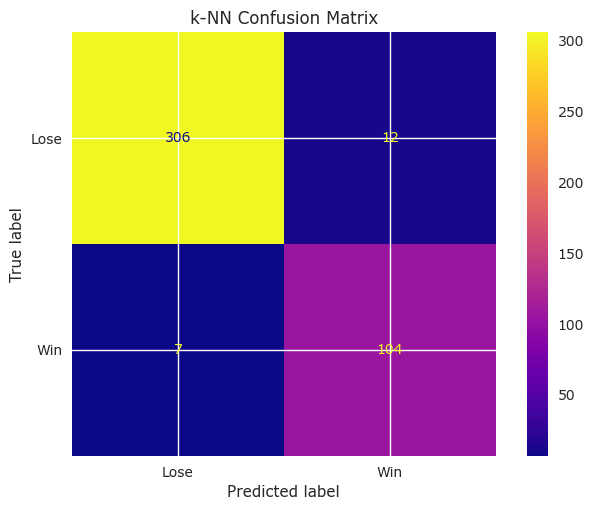

In [54]:


cm_knn = confusion_matrix(y_test, knn.predict(X_test_mm), labels=knn.classes_)

ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=['Lose','Win']).plot(cmap=plt.cm.plasma)

plt.title('k-NN Confusion Matrix')


In [55]:

from matplotlib.colors import ListedColormap

H = house.copy(deep=True)

H['inc'] = H['inc'].map({'Incumbent':1,'Challenger':2,'Open':0})

H['tot_rec'] = ( H['tot_rec'] - min(H['tot_rec']) ) / ( max(H['tot_rec']) - min(H['tot_rec']) )

X = H[['inc','tot_rec']]

y = H['winner']

opt_k = knn.get_params()['n_neighbors']

h = .05  

cmap_light = ListedColormap(['#cea2fd','#8cffdb'])
cmap_bold = ListedColormap(['#9c6da5','#04d8b2'])

clf = KNeighborsClassifier(n_neighbors=opt_k)
clf.fit(X, y)

x_min, x_max = X['inc'].min() - 1, X['inc'].max() + 1
y_min, y_max = X['tot_rec'].min() - 1, X['tot_rec'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

sns.swarmplot(data=H, x='inc', y='tot_rec', hue='winner', palette=['#9c6da5','#04d8b2'])
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("k-NN Decision Boundary (k = {})".format(str(opt_k)), fontsize=14)
plt.xticks(ticks=[0,1,2], labels=['Challenger','Incumbent','Open'])
plt.xlabel('Incumbency', fontsize=12)
plt.ylabel('Total Contributions', fontsize=12)

plt.show()

KeyboardInterrupt: 

#### Support Vector Machine

In [ ]:

svc_grid = {'C':[0.01,0.1,0.25,0.5,0.75,1], 'kernel':['libear','rbf', 'sigmoid'],
            'gamma':['scale','auto']}

svc = optimizer(SVC(), svc_grid, X_train_mm, y_train)

svc.fit(X_train_mm, y_train)


SVC(C=0.01)

In [ ]:
print(classification_report(svc.predict(X_test_mm), y_test))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97       327
           1       0.88      0.96      0.92       102

    accuracy                           0.96       429
   macro avg       0.94      0.96      0.95       429
weighted avg       0.96      0.96      0.96       429



Text(0.5, 1.0, 'SVC Confusion Matrix')

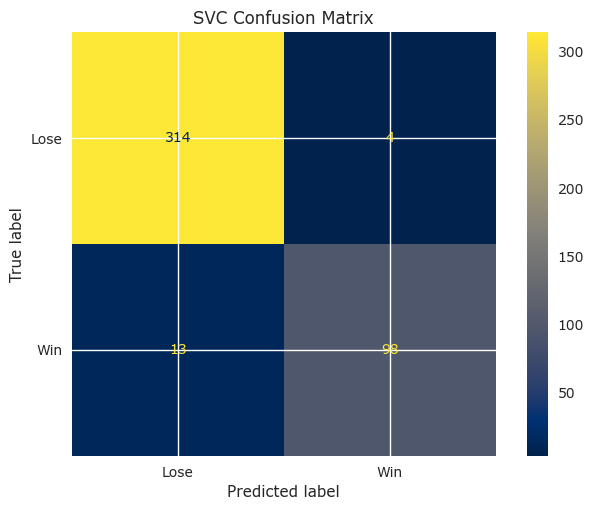

In [ ]:
cm_svc = confusion_matrix(y_test, svc.predict(X_test_mm), labels=svc.classes_)

ConfusionMatrixDisplay(confusion_matrix=cm_svc, display_labels=['Lose','Win']).plot(cmap=plt.cm.cividis)

plt.title('SVC Confusion Matrix')

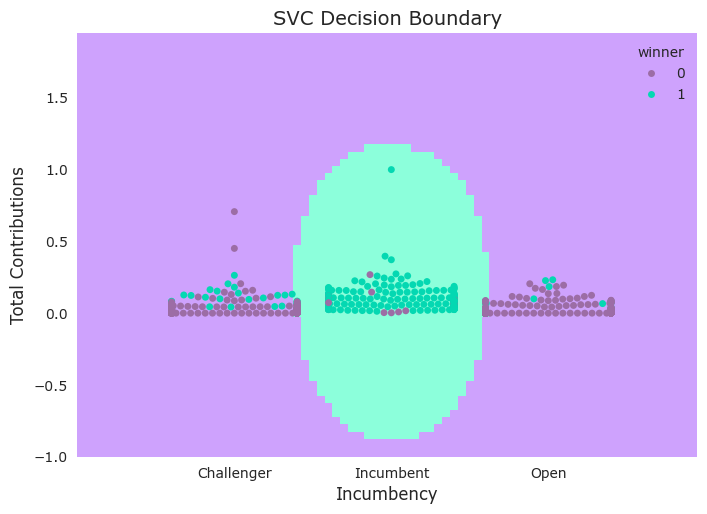

In [59]:
from matplotlib.colors import ListedColormap

H = house.copy(deep=True)

H['inc'] = H['inc'].map({'Incumbent':1,'Challenger':2,'Open':0})

H['tot_rec'] = ( H['tot_rec'] - min(H['tot_rec']) ) / ( max(H['tot_rec']) - min(H['tot_rec']) )

X = H[['inc','tot_rec']]

y = H['winner']

h = .05  

cmap_light = ListedColormap(['#cea2fd','#8cffdb'])
cmap_bold = ListedColormap(['#9c6da5','#04d8b2'])

clf = svc
clf.fit(X, y)

x_min, x_max = X['inc'].min() - 1, X['inc'].max() + 1
y_min, y_max = X['tot_rec'].min() - 1, X['tot_rec'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

sns.swarmplot(data=H, x='inc', y='tot_rec', hue='winner', palette=['#9c6da5','#04d8b2'])
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("SVC Decision Boundary", fontsize=14)
plt.xticks(ticks=[0,1,2], labels=['Challenger','Incumbent','Open'])
plt.xlabel('Incumbency', fontsize=12)
plt.ylabel('Total Contributions', fontsize=12)

plt.show()


#### Decision Tree

In [60]:
tree_grid = {'criterion':['gini','entropy','log_loss'], 'max_depth':range(2,10), 'ccp_alpha': [0.1,0.01,0.001,0]}

tree = optimizer(DecisionTreeClassifier(), tree_grid, X_train_mm, y_train)

tree.fit(X_train_mm, y_train)

DecisionTreeClassifier(ccp_alpha=0.001, criterion='entropy', max_depth=4)

In [61]:
print(classification_report(tree.predict(X_test_mm), y_test))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       315
           1       0.91      0.89      0.90       114

    accuracy                           0.95       429
   macro avg       0.93      0.93      0.93       429
weighted avg       0.95      0.95      0.95       429



Text(0.5, 1.0, 'Decision Tree Confusion Matrix')

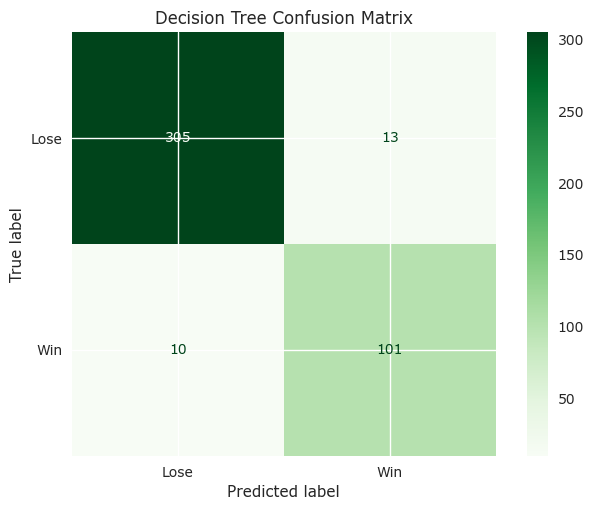

In [62]:

cm_tree = confusion_matrix(y_test, tree.predict(X_test_mm), labels=tree.classes_)

ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=['Lose','Win']).plot(cmap=plt.cm.Greens)

plt.title('Decision Tree Confusion Matrix')


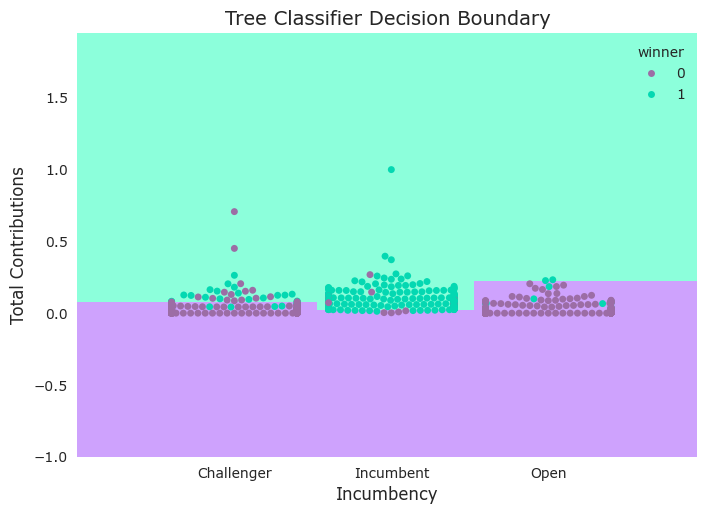

In [ ]:

from matplotlib.colors import ListedColormap

H = house.copy(deep=True)

H['inc'] = H['inc'].map({'Incumbent':1,'Challenger':2,'Open':0})

H['tot_rec'] = ( H['tot_rec'] - min(H['tot_rec']) ) / ( max(H['tot_rec']) - min(H['tot_rec']) )

X = H[['inc','tot_rec']]

y = H['winner']

h = .05  

cmap_light = ListedColormap(['#cea2fd','#8cffdb'])
cmap_bold = ListedColormap(['#9c6da5','#04d8b2'])

clf = tree
clf.fit(X, y)

x_min, x_max = X['inc'].min() - 1, X['inc'].max() + 1
y_min, y_max = X['tot_rec'].min() - 1, X['tot_rec'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

sns.swarmplot(data=H, x='inc', y='tot_rec', hue='winner', palette=['#9c6da5','#04d8b2'])
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("Tree Classifier Decision Boundary", fontsize=14)
plt.xticks(ticks=[0,1,2], labels=['Challenger','Incumbent','Open'])
plt.xlabel('Incumbency', fontsize=12)
plt.ylabel('Total Contributions', fontsize=12)

plt.show()


## Multilayer Perceptron

In [64]:
mlp_grid = {'hidden_layer_sizes':[(j,j,j) for j in range(10,30,10)], 'activation':['indentity','logistic','tanh','relu'], 
        'solver':['lbfgs','sgd','adam']}

mlp = optimizer(MLPClassifier(random_state=137), mlp_grid, X_train_mm, y_train)

mlp.fit(X_train_mm, y_train)

MLPClassifier(activation='logistic', hidden_layer_sizes=(10, 10, 10),
              random_state=137, solver='lbfgs')

In [65]:
print(classification_report(mlp.predict(X_test_mm), y_test))

report_dict = classification_report(y_test, mlp.predict(X_test_mm), output_dict=True)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       313
           1       0.94      0.90      0.92       116

    accuracy                           0.96       429
   macro avg       0.95      0.94      0.94       429
weighted avg       0.96      0.96      0.96       429



Text(0.5, 1.0, 'Triple-Layer Perceptron Confusion Matrix')

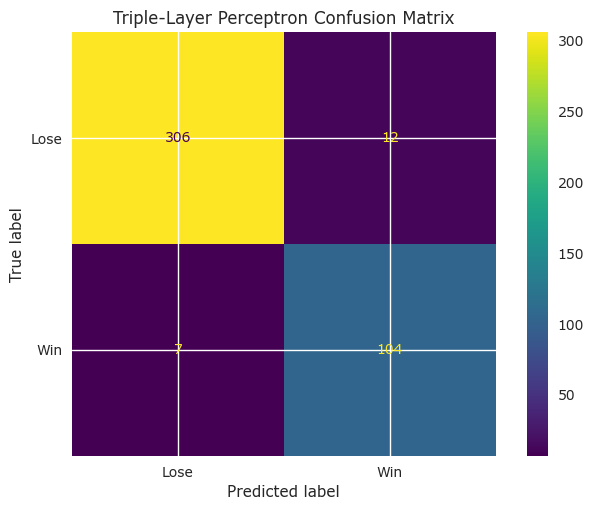

In [ ]:
cm_mlp = confusion_matrix(y_test, mlp.predict(X_test_mm), labels=mlp.classes_)

ConfusionMatrixDisplay(confusion_matrix=cm_mlp, display_labels=['Lose','Win']).plot(cmap=plt.cm.viridis)

plt.title('Triple-Layer Perceptron Confusion Matrix')

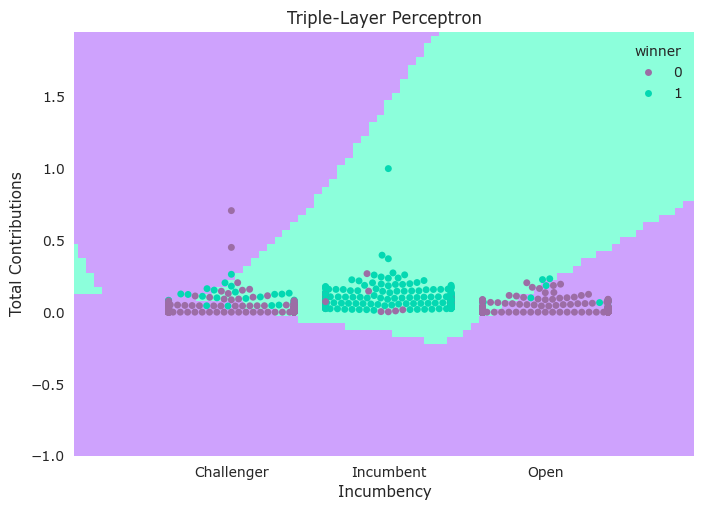

In [67]:
from matplotlib.colors import ListedColormap

H = house.copy(deep=True)

H['inc'] = H['inc'].map({'Incumbent':1,'Challenger':2,'Open':0})

H['tot_rec'] = ( H['tot_rec'] - min(H['tot_rec']) ) / ( max(H['tot_rec']) - min(H['tot_rec']) )

X = H[['inc','tot_rec']]

y = H['winner']

h = .05  

cmap_light = ListedColormap(['#cea2fd','#8cffdb'])
cmap_bold = ListedColormap(['#9c6da5','#04d8b2'])

clf = MLPClassifier(hidden_layer_sizes=(10,10,10), activation='logistic', solver='lbfgs', random_state=137)
clf.fit(X, y)

x_min, x_max = X['inc'].min() - 1, X['inc'].max() + 1
y_min, y_max = X['tot_rec'].min() - 1, X['tot_rec'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

sns.swarmplot(data=H, x='inc', y='tot_rec', hue='winner', palette=['#9c6da5','#04d8b2'])
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title('Triple-Layer Perceptron')
plt.xticks(ticks=[0,1,2], labels=['Challenger','Incumbent','Open'])
plt.xlabel('Incumbency')
plt.ylabel('Total Contributions')

plt.show()